# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [316]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

from utils import util

In [317]:
from importlib import reload  
from utils import util
util = reload(util)

In [318]:
# Set random seed for reproducibility
import warnings
warnings.filterwarnings("ignore")
seed = 23 #125 84 42
util.fix_random_seed(seed)

## 1. Load and inspect the dataset

### 1.1. Load data

In [319]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [320]:
display(df)

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.918877,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274543,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.950230,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274544,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.602938,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274545,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.877878,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513


In [321]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


### 1.2 Geographic plot of locations in northern Italy

In [322]:
# This split is just to make the geographic plot
train_df, val_df, test_df = util.train_val_test_split(df, df_indexes_test)

In [323]:
# Run this cell only once to create the .tif file
'''from osgeo import gdal

# Definire i parametri di georeferenziazione dal file .jpgw
geotransform = [261600.0, 100.0, 0.0, 5296000.0, 0.0, -100.0]

# Aprire il file JPG originale con GDAL
ds = gdal.Open('Italia_tinitaly.jpg', gdal.GA_ReadOnly)

# Creare un driver TIFF per il salvataggio del file
driver = gdal.GetDriverByName('GTiff')

# Creare una copia del file originale, questa volta in formato TIFF
ds_tiff = driver.CreateCopy('Italia_tinitaly.tif', ds, 0)

# Assegnare il sistema di riferimento spaziale e la geotrasformazione al file TIFF
ds_tiff.SetProjection('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')
ds_tiff.SetGeoTransform(geotransform)

# Salvare e chiudere i dataset
ds_tiff.FlushCache()
ds_tiff = None
ds = None'''


'from osgeo import gdal\n\n# Definire i parametri di georeferenziazione dal file .jpgw\ngeotransform = [261600.0, 100.0, 0.0, 5296000.0, 0.0, -100.0]\n\n# Aprire il file JPG originale con GDAL\nds = gdal.Open(\'Italia_tinitaly.jpg\', gdal.GA_ReadOnly)\n\n# Creare un driver TIFF per il salvataggio del file\ndriver = gdal.GetDriverByName(\'GTiff\')\n\n# Creare una copia del file originale, questa volta in formato TIFF\nds_tiff = driver.CreateCopy(\'Italia_tinitaly.tif\', ds, 0)\n\n# Assegnare il sistema di riferimento spaziale e la geotrasformazione al file TIFF\nds_tiff.SetProjection(\'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORIT

In [324]:
# import pandas as pd
# from PIL import Image, ImageDraw
# from osgeo import gdal

# # Carica l'immagine georeferenziata TIFF
# image_path = 'img/Italia_tinitaly.tif'
# image = Image.open(image_path)

# # Calcola le dimensioni dell'immagine
# width, height = image.size

# # Carica il file TIFF con GDAL per accedere alle informazioni georeferenziate
# ds = gdal.Open(image_path)

# # Ottieni la geotrasformazione dal dataset
# gt = ds.GetGeoTransform()

# def world_to_pixel(geo_matrix, x, y):
#     """
#     Usa la geotrasformazione del dataset per convertire le coordinate geografiche in coordinate pixel
#     """
#     ulX = geo_matrix[0]
#     ulY = geo_matrix[3]
#     xDist = geo_matrix[1]
#     yDist = geo_matrix[5]
#     rtnX = geo_matrix[2]
#     rtnY = geo_matrix[4]
#     pixel = int((x - ulX) / xDist)
#     line = int((ulY - y) / xDist)
#     return (pixel, line)

# # Crea un oggetto draw per disegnare sull'immagine
# draw = ImageDraw.Draw(image)

# # Imposta la dimensione del pallino per i punti
# #point_radius = 20

# # Definisci una funzione per disegnare i punti
# def draw_points(df, color):
#     for index, row in df.iterrows():
#         r = row['value_count']/10  # Raggio del cerchio basato sulla feature
#         pixel_coords = world_to_pixel(gt, row['X'], row['Y'])
#         draw.ellipse(
#             (pixel_coords[0] - r, pixel_coords[1] - r, 
#              pixel_coords[0] + r, pixel_coords[1] + r),
#             fill=color
#         )


# train_df['value_count'] = train_df.groupby('ID')['ID'].transform('count')       
# test_df['value_count'] = test_df.groupby('ID')['ID'].transform('count') 
 
# # Disegna i punti del train set in nero
# draw_points(train_df, 'black')     

# # Disegna i punti del test set in bianco
# draw_points(test_df, 'white')

# # Salva l'immagine modificata
# image.save('img/Italia_tinitaly_with_points.jpg')

# # Chiudi l'oggetto dataset di GDAL
# ds = None

### 1.3 Preprocess and split the dataset

In [325]:
# Standardize the data
df_std = util.standardize(df, 'gumbel')
# delete the column 'loc' and 'scale'
df_std = df_std.drop(['loc', 'scale'], axis=1, inplace=False)

In [326]:
df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,1.221239,28.250000,1.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.809340,4.673003,0.433955,-0.800952
1,5001.0,0.778761,28.250000,1.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.809340,4.673003,0.433955,-0.800952
2,5002.0,1.219018,33.469565,1.0,-0.005666,-0.495691,-0.502626,-0.492549,1.348947,1.486396,...,-1.100980,0.288846,-0.428899,-0.360315,1.047773,-0.366761,0.743587,-0.185967,-0.173545,-0.458485
3,5002.0,0.979995,33.469565,1.0,-0.005666,-0.495691,-0.502626,-0.492549,1.348947,1.486396,...,-1.100980,0.288846,-0.428899,-0.360315,1.047773,-0.366761,0.743587,-0.185967,-0.173545,-0.458485
4,5002.0,1.153287,33.469565,1.0,-0.005666,-0.495691,-0.502626,-0.492549,1.348947,1.486396,...,-1.100980,0.288846,-0.428899,-0.360315,1.047773,-0.366761,0.743587,-0.185967,-0.173545,-0.458485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338.0,0.918877,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146
274543,21338.0,0.950230,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146
274544,21338.0,0.602938,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146
274545,21338.0,0.877878,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146


In [327]:
# Split the dataset into train, validation and test
train_df_std, val_df_std, test_df_std = util.train_val_test_split(df_std, df_indexes_test)
min_AMS = train_df_std['AMS'].min()
max_AMS = train_df_std['AMS'].max()

train_df_std = util.scale_AMS(train_df_std, min_AMS, max_AMS) 
val_df_std = util.scale_AMS(val_df_std, min_AMS, max_AMS) 
test_df_std = util.scale_AMS(test_df_std, min_AMS, max_AMS) 

In [328]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [329]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.162028,28.25,1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001,0.103407,28.25,1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001,0.146866,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001,0.118569,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001,0.157156,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


In [330]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.132718,57.047139,9.196126,0.024646,0.032570,0.042734,0.047496,0.014040,0.013421,...,-0.102764,0.028934,-0.070270,-0.067010,0.023610,0.001521,0.037728,0.004899,-0.072880,-0.075678
std,4333.130131,0.049723,31.055424,8.279490,0.984392,0.986320,0.981766,0.976423,1.004977,1.008808,...,0.986101,1.052469,1.018725,1.018695,0.996458,1.002549,0.995037,1.018041,0.989454,1.016837
min,5001.000000,0.001325,5.200000,1.000000,-1.020500,-1.181048,-1.331852,-1.503806,-4.369229,-3.522613,...,-1.470102,-1.519984,-1.779005,-1.935638,-1.583809,-0.479600,-1.528887,-0.637763,-2.037322,-1.886456
25%,8094.000000,0.099157,34.977778,3.000000,-0.708747,-0.817296,-0.887690,-0.666054,-0.578875,-0.620972,...,-0.984027,-0.582172,-0.864855,-0.799420,-0.757122,-0.452740,-0.764904,-0.515773,-0.969827,-0.868411
50%,12005.000000,0.123613,49.674286,6.000000,-0.264208,-0.091967,0.073687,0.116867,0.016296,0.066203,...,-0.148547,-0.118672,-0.208966,-0.251402,-0.210103,-0.420647,-0.187105,-0.435802,0.079379,-0.371707
75%,16065.000000,0.155474,70.343750,12.000000,0.480086,0.640557,0.730073,0.713190,0.644833,0.693127,...,0.563731,0.423661,0.582830,0.456927,0.596341,-0.225321,0.667556,-0.095920,0.699596,0.724815
max,20034.000000,0.833372,318.742857,24.000000,5.244876,3.734721,2.928541,3.520526,3.648847,2.935948,...,2.408305,5.536860,3.648605,3.272980,4.323812,7.312002,3.537003,6.218626,2.054450,2.471653


In [331]:
def add_loc_scale(df):
 
    # create two empy columns for alpha and beta
    df['loc'] = np.nan
    df['scale'] = np.nan
 
    for id in df['ID'].unique():
       
        for duration in DURATION:
            condition = (df['ID'] == id) & (df['duration[h]'] == duration)
            ams = df[condition]['AMS']
            
            if len(ams) < 29:
                loc, scale = np.nan, np.nan
            else:
                loc, scale = stats.gumbel_r.fit(ams)   
                        
            df.loc[condition, 'loc'] = loc
            df.loc[condition, 'scale'] = scale
 
    df.dropna(inplace=True)
 
    return df

In [332]:
test_df_std = add_loc_scale(test_df_std)
train_df_std = add_loc_scale(train_df_std)
val_df_std = add_loc_scale(val_df_std)

### 1.4 Loc and scale inspection

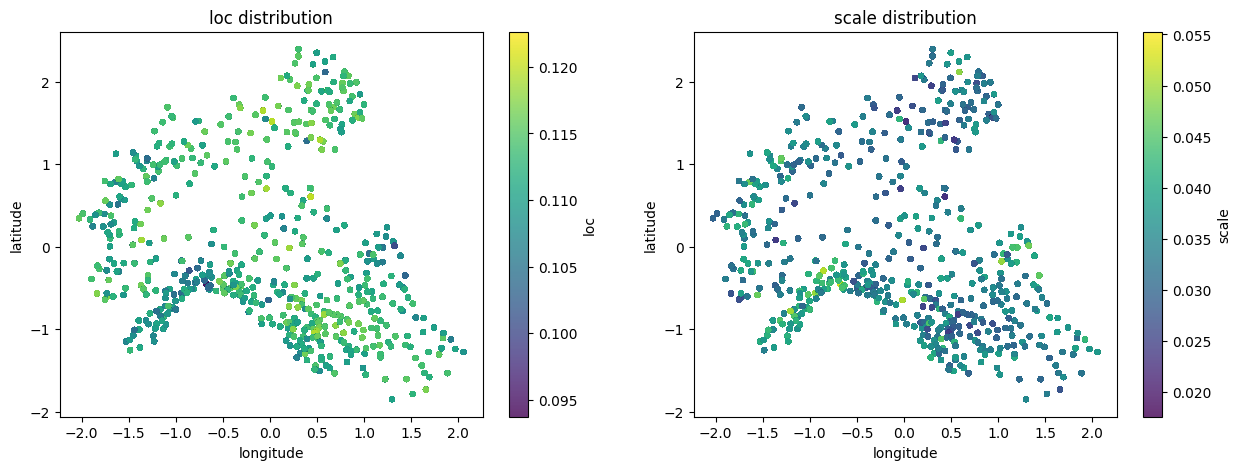

In [333]:
util.geographic_plot(train_df_std, 'loc', 'scale')

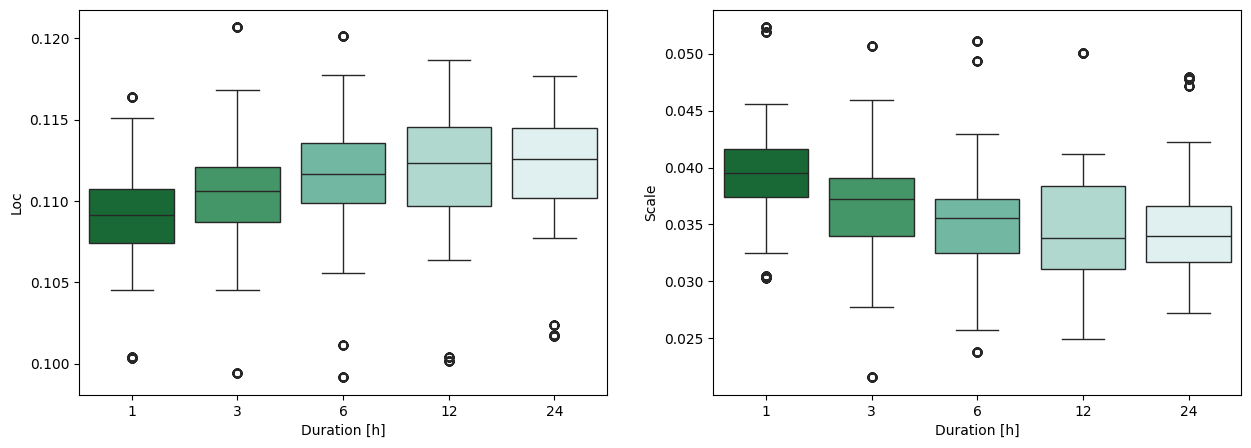

In [334]:
#boxplot of alpha and beta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#sns.set(rc={'axes.facecolor': '#071C42', 'figure.facecolor': '#071C42', 'text.color':'white'})

#ALPHA
sns.boxplot(x='duration[h]', y='loc', data=test_df_std, ax=ax[0], palette='BuGn_r')

# Set both x and y axis color to white
ax[0].tick_params(axis='x')
ax[0].tick_params(axis='y')

# Set axes titles color to white
ax[0].set_xlabel("Duration [h]")
ax[0].set_ylabel("Loc")

#BETA
sns.boxplot(x='duration[h]', y='scale', data=test_df_std, ax=ax[1], palette='BuGn_r')

ax[1].tick_params(axis='x')
ax[1].tick_params(axis='y')

# Set axes titles color to white
ax[1].set_xlabel("Duration [h]")
ax[1].set_ylabel("Scale")

plt.show()

In [335]:
sns.reset_defaults()

In [336]:
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = test_df_std.groupby(['ID','duration[h]'])['loc'].mean()
AMS_count['scale'] = test_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5005 1               64  0.109630  0.037899
     3               64  0.109951  0.037229
     6               64  0.110515  0.035955
     12              64  0.111238  0.036457
     24              64  0.112343  0.034367
5015 1               76  0.113908  0.033347
     3               76  0.116801  0.027721
     6               77  0.116926  0.027284
     12              78  0.116549  0.026957
     24              77  0.115250  0.029387
5143 1               69  0.110942  0.037416
     3               70  0.112106  0.036622
     6               70  0.113162  0.036043
     12              70  0.109141  0.039318
     24              70  0.113214  0.036487

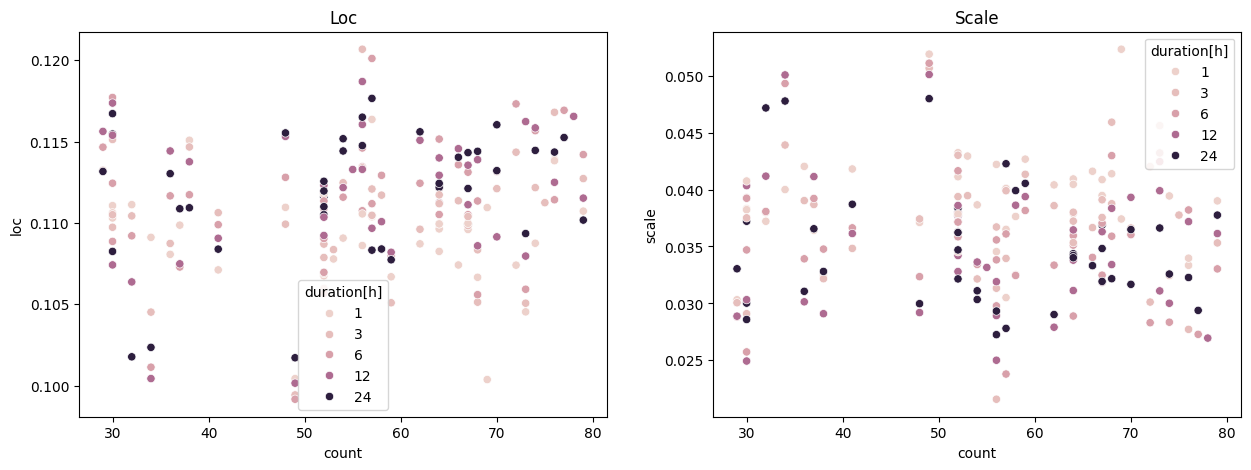

In [337]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

### 1.5 Prepare data for training

In [338]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [339]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'loc', 'scale'],
      dtype='object')

In [340]:
# take all the columns except 'ID', 'AMS', 'mean_IdD', 'loc', 'scale' as input, and 'AMS' as output
input_columns = train_df_std.columns[3:-2]  
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [341]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
#parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
#parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [342]:
inputs_train.columns

Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [343]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
133,-0.997403,-1.166102,-1.312192,-1.471304,-0.149445,0.231847,-1.236669,-1.310886,-1.374450,-1.516939,...,-0.436697,-1.369140,-0.496008,1.038116,-0.177040,1,0,0,0,0
134,-0.997403,-1.166102,-1.312192,-1.471304,-0.149445,0.231847,-1.236669,-1.310886,-1.374450,-1.516939,...,-0.436697,-1.369140,-0.496008,1.038116,-0.177040,1,0,0,0,0
135,-0.997403,-1.166102,-1.312192,-1.471304,-0.149445,0.231847,-1.236669,-1.310886,-1.374450,-1.516939,...,-0.436697,-1.369140,-0.496008,1.038116,-0.177040,1,0,0,0,0
136,-0.997403,-1.166102,-1.312192,-1.471304,-0.149445,0.231847,-1.236669,-1.310886,-1.374450,-1.516939,...,-0.436697,-1.369140,-0.496008,1.038116,-0.177040,1,0,0,0,0
137,-0.997403,-1.166102,-1.312192,-1.471304,-0.149445,0.231847,-1.236669,-1.310886,-1.374450,-1.516939,...,-0.436697,-1.369140,-0.496008,1.038116,-0.177040,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232886,1.282102,2.310280,2.086383,2.189841,1.037607,-0.215719,1.322874,-0.291414,0.227587,1.209569,...,1.036990,0.667556,1.634332,-1.302297,1.070449,0,0,0,0,1
232887,1.282102,2.310280,2.086383,2.189841,1.037607,-0.215719,1.322874,-0.291414,0.227587,1.209569,...,1.036990,0.667556,1.634332,-1.302297,1.070449,0,0,0,0,1
232888,1.282102,2.310280,2.086383,2.189841,1.037607,-0.215719,1.322874,-0.291414,0.227587,1.209569,...,1.036990,0.667556,1.634332,-1.302297,1.070449,0,0,0,0,1
232889,1.282102,2.310280,2.086383,2.189841,1.037607,-0.215719,1.322874,-0.291414,0.227587,1.209569,...,1.036990,0.667556,1.634332,-1.302297,1.070449,0,0,0,0,1


In [344]:
# Inputs to train a model with only MAP and duration

inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
133,-1.250229,1,0,0,0,0
134,-1.250229,1,0,0,0,0
135,-1.250229,1,0,0,0,0
136,-1.250229,1,0,0,0,0
137,-1.250229,1,0,0,0,0
...,...,...,...,...,...,...
232886,0.245840,0,0,0,0,1
232887,0.245840,0,0,0,0,1
232888,0.245840,0,0,0,0,1
232889,0.245840,0,0,0,0,1


In [345]:
# Inputs to train a model after applying PCA

inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca

,0,1,2,3,4
0,-3.063081,3.185058,0.441383,0.804058,0.314251
1,-3.063081,3.185058,0.441383,0.804058,0.314251
2,-3.063081,3.185058,0.441383,0.804058,0.314251
3,-3.063081,3.185058,0.441383,0.804058,0.314251
4,-3.063081,3.185058,0.441383,0.804058,0.314251
...,...,...,...,...,...
135469,4.633873,-0.421197,-0.116528,0.846259,-0.484011
135470,4.633873,-0.421197,-0.116528,0.846259,-0.484011
135471,4.633873,-0.421197,-0.116528,0.846259,-0.484011
135472,4.633873,-0.421197,-0.116528,0.846259,-0.484011


## 2. Model definition

In [346]:
def build_nn_gumbel_model(input_shape, hidden, seed):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    
    mu_logsig = layers.Dense(2, activation='linear',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

## 3. Training

### 3.1  MAP-model

In [347]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [348]:
# Hyperparameters for training
hidden_layers = [256,128]
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...
Epoch 1/90
1059/1059 [==============================] - 6s 4ms/step - loss: -1.4647 - val_loss: -1.6321
Epoch 2/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6658 - val_loss: -1.6621
Epoch 3/90
1059/1059 [==============================] - 4s 3ms/step - loss: -1.6702 - val_loss: -1.6991
Epoch 4/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6749 - val_loss: -1.6268
Epoch 5/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6751 - val_loss: -1.6930
Epoch 6/90
1059/1059 [==============================] - 4s 3ms/step - loss: -1.6799 - val_loss: -1.6832
Epoch 7/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6763 - val_loss: -1.6865
Epoch 8/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6772 - val_loss: -1.7046
Epoch 9/90
1059/1059 [==============================] - 4s 3ms/step - loss: -1.6867 - val_loss: -1.6533
Epoch 10/90
1059/

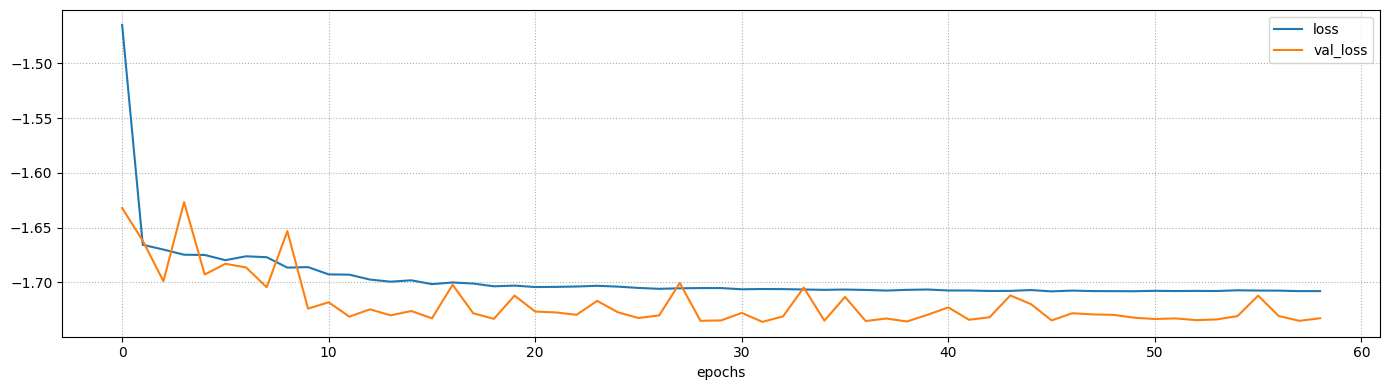

Final loss: -1.7081 (training), -1.7330 (validation)


In [349]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_gumbel_model(input_shape=(X_train_map.shape[1],), hidden=hidden_layers, seed=seed) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1059/1059 [==============================] - 5s 4ms/step - loss: -1.1769 - val_loss: -1.1007
Epoch 2/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.5834 - val_loss: -1.4950
Epoch 3/90
1059/1059 [==============================] - 5s 4ms/step - loss: -1.6507 - val_loss: -1.4172
Epoch 4/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6755 - val_loss: -1.6367
Epoch 5/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6890 - val_loss: -1.6396
Epoch 6/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6991 - val_loss: -1.6870
Epoch 7/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.7026 - val_loss: -1.7115
Epoch 8/90
1059/1059 [==============================] - 4s 3ms/step - loss: -1.7059 - val_loss: -1.7093
Epoch 9/90
1059/1059 [==============================] - 4s 3ms/step - loss: -1.7105 - val_loss: -1.7219
Epoch 

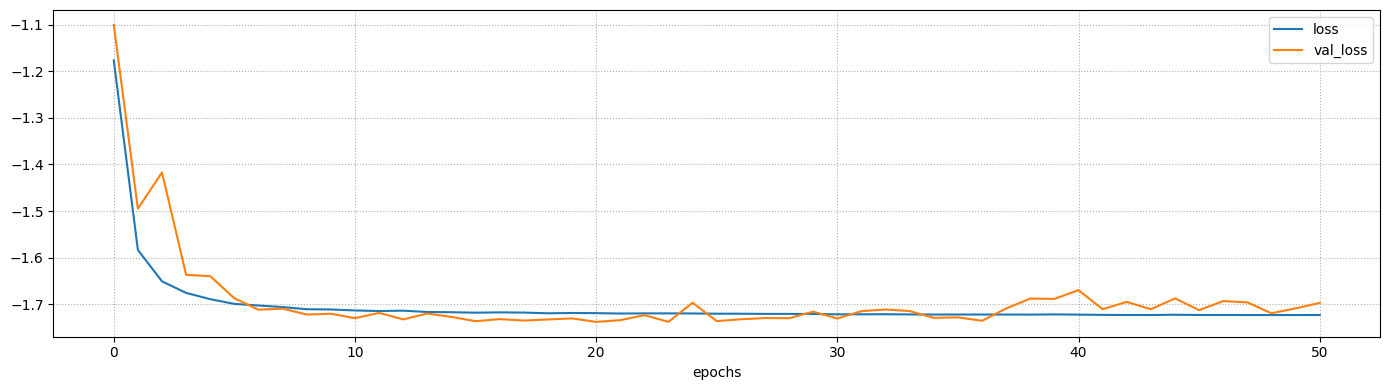

Final loss: -1.7230 (training), -1.6970 (validation)


In [350]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3 PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
1059/1059 [==============================] - 5s 4ms/step - loss: -0.4326 - val_loss: -1.1772
Epoch 2/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.3635 - val_loss: -1.4064
Epoch 3/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.5778 - val_loss: -1.5999
Epoch 4/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6273 - val_loss: -1.5879
Epoch 5/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6340 - val_loss: -1.6384
Epoch 6/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6365 - val_loss: -1.6506
Epoch 7/90
1059/1059 [==============================] - 4s 3ms/step - loss: -1.6572 - val_loss: -1.6155
Epoch 8/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6716 - val_loss: -1.6645
Epoch 9/90
1059/1059 [==============================] - 4s 4ms/step - loss: -1.6852 - val_loss: -1.

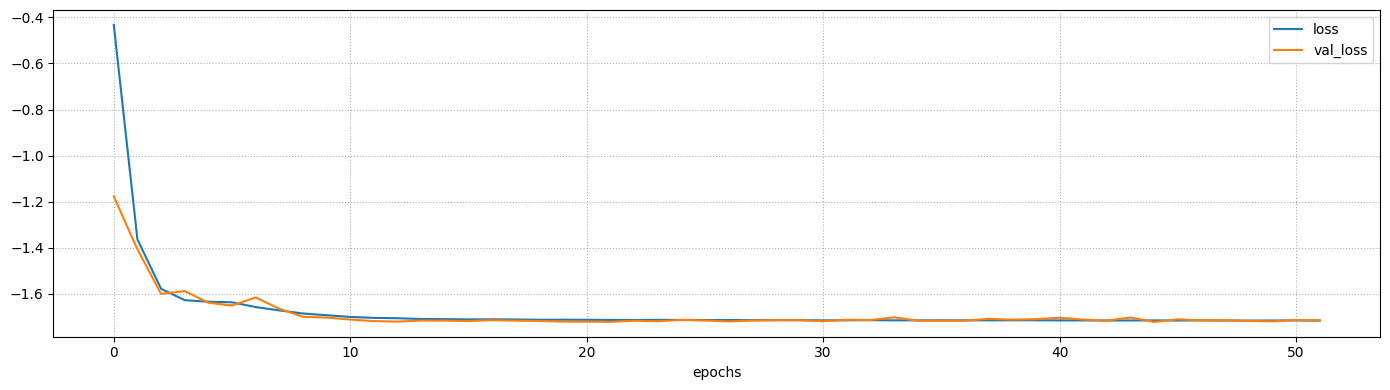

Final loss: -1.7159 (training), -1.7147 (validation)


In [351]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_gumbel_model(input_shape=(X_train_pca.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Predictions

In [352]:
dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)

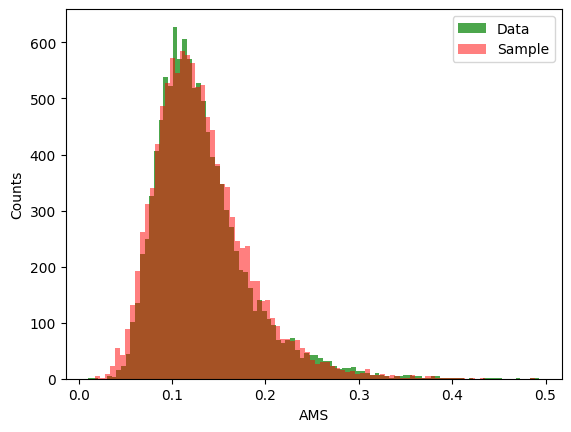

In [353]:
y_pred = dist_test_full.sample(1).numpy().ravel()
#y_pred = dist_train_map.sample(1).numpy().ravel()
#y_pred = dist_test_pca.sample(1).numpy().ravel()

util.plot_hist_samples(y_test, y_pred, 'red')

### 4.1 Confidence interval 

In [354]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


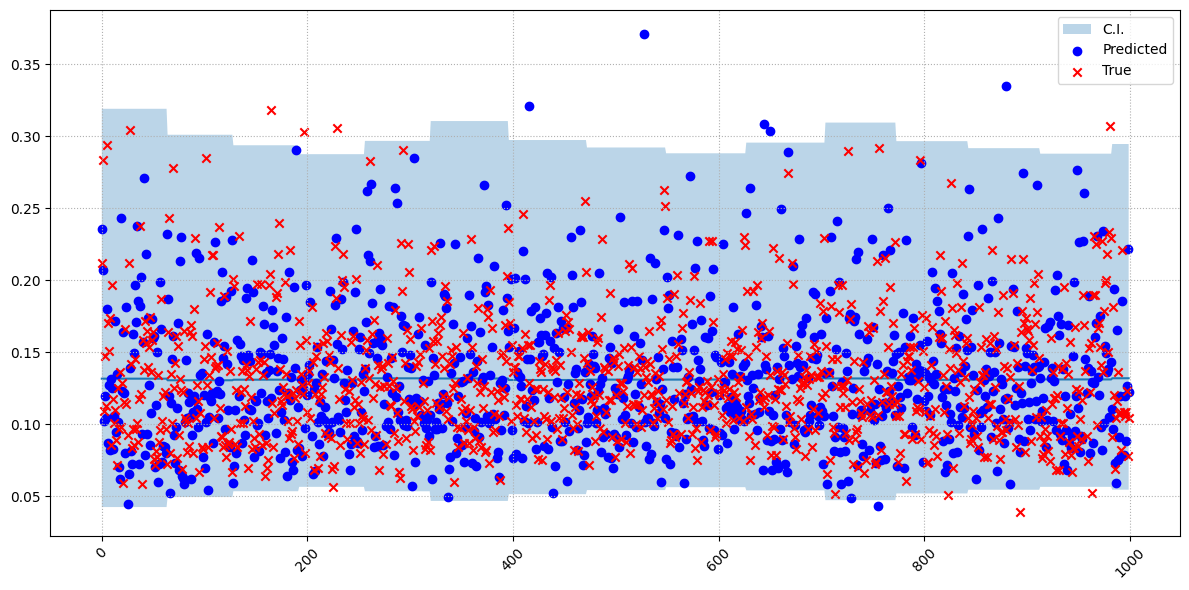

Percentage of values inside the 99% confidence interval: 98.29%


In [355]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


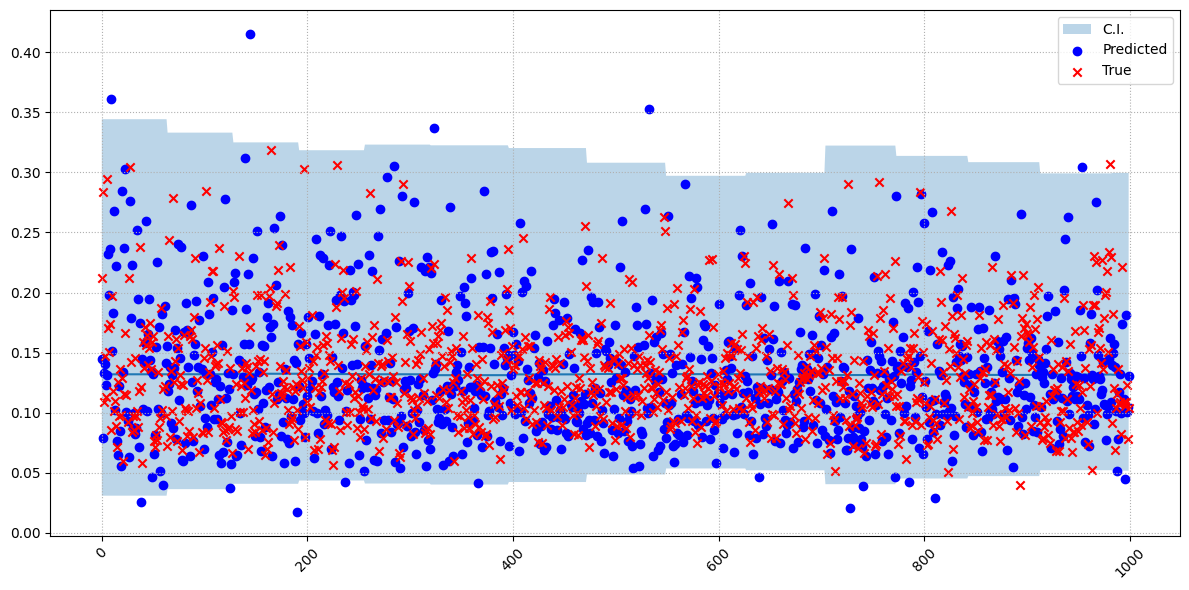

Percentage of values inside the 99% confidence interval: 99.07%


In [356]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


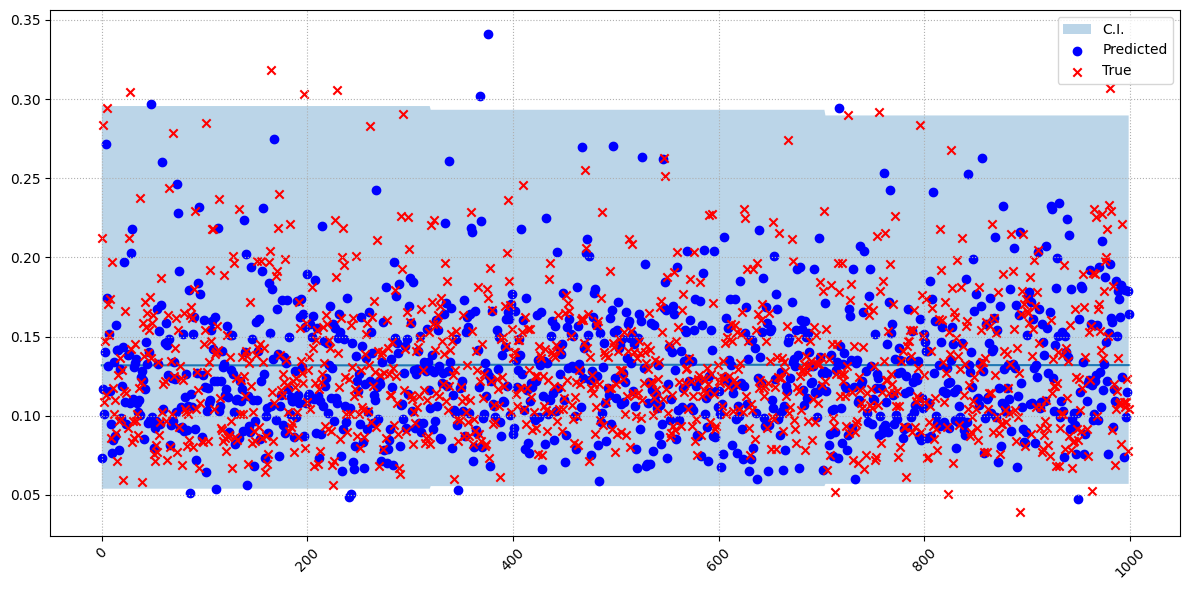

Percentage of values inside the 99% confidence interval: 98.56%


In [357]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters metrics

Metrics on parameters from MAP-model

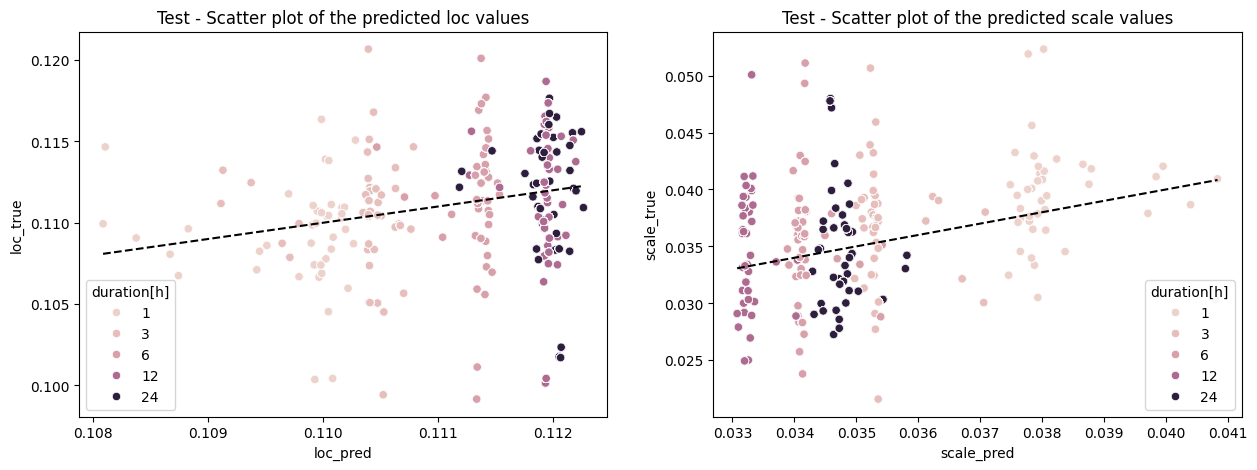

In [358]:
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_map, metrics_scale_map = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [359]:
print('=============== LOC PARAMETER===============')
display(metrics_loc_map)
print('===============SCALE PARAMETER==============')
metrics_scale_map

=============== LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.001069,-0.007224,-0.000021,0.001195,-0.000615,0.001327
mape,0.024692,0.022378,0.024064,0.026015,0.026201,0.024803
pcc,0.267828,-0.014732,-0.067319,-0.004487,-0.062211,-0.067017


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,0.006456,0.022324,0.013176,0.002147,0.018898,-0.024337
mape,0.108201,0.084826,0.114311,0.114505,0.119720,0.107652
pcc,0.318269,-0.010904,-0.089721,-0.042969,-0.007712,-0.065806


Metrics on parameters from Full-model

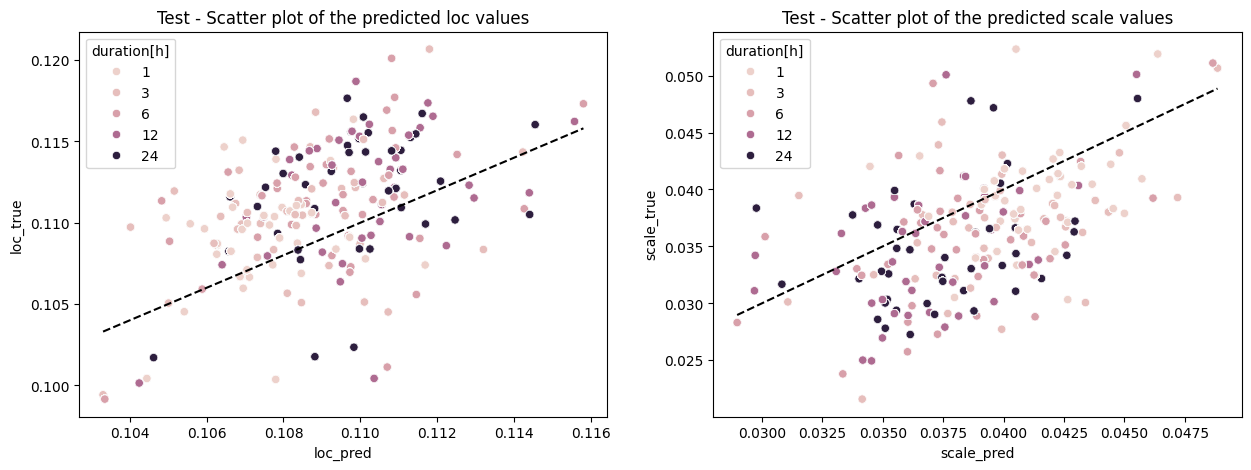

In [360]:
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_full, metrics_scale_full = util.parameters_metrics(dist_test_full, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [361]:
print('===============LOC PARAMETER===============')
display(metrics_loc_full)
print('===============SCALE PARAMETER ==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,0.016440,0.013180,0.015964,0.018046,0.015140,0.019879
mape,0.028934,0.025902,0.028256,0.031249,0.028126,0.031142
pcc,0.465206,0.257803,0.434867,0.430828,0.414908,0.360546


===============SCALE PARAMETER ==============


,global,1,3,6,12,24
biasr,-0.085775,-0.051470,-0.093183,-0.103838,-0.080861,-0.099574
mape,0.129527,0.095882,0.127052,0.142660,0.134270,0.147823
pcc,0.486326,0.273175,0.470486,0.450703,0.431173,0.308774


Metrics on parameters from PCA-model

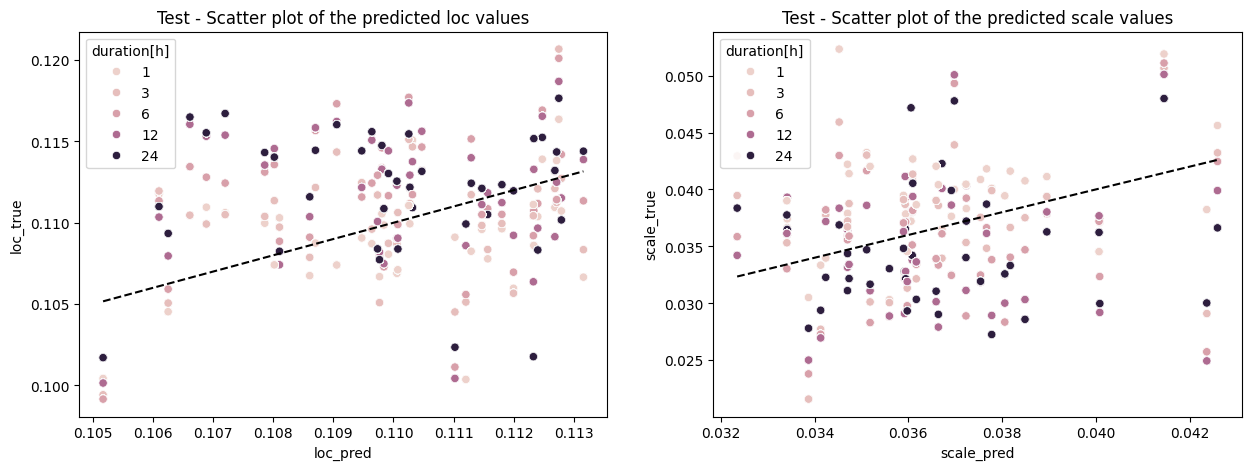

In [362]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_pca, metrics_scale_pca = util.parameters_metrics(dist_test_pca, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [363]:
print('===============LOC PARAMETER===============')
display(metrics_loc_pca)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,0.007133,-0.010507,0.001905,0.011734,0.015276,0.017287
mape,0.028752,0.024607,0.026124,0.030340,0.031501,0.031194
pcc,0.211730,0.320090,0.339534,0.243312,0.124216,0.092298


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.085775,-0.051470,-0.093183,-0.103838,-0.080861,-0.099574
mape,0.129527,0.095882,0.127052,0.142660,0.134270,0.147823
pcc,0.486326,0.273175,0.470486,0.450703,0.431173,0.308774


### 5.1  Comparison between two samples extracted from "true" and predicted distribution of the same place 

In [364]:
util = reload(util)

True loc: 0.11, Predicted loc: 0.11
True scale: 0.04, Predicted scale: 0.04
KS statistics:  0.0405
p-value:  1.4994173877292366e-07


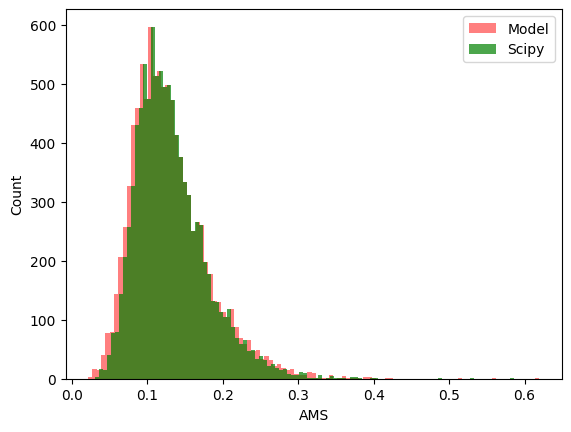

In [365]:
# Anzola dell'Emilia -> index 9252
util.compare_samples(dist_test_full, "gumbel", parameters_test, seed = seed, index=9252)

True loc: 0.12, Predicted loc: 0.11
True scale: 0.03, Predicted scale: 0.04
KS statistics:  0.1147
p-value:  1.1010000860636555e-57


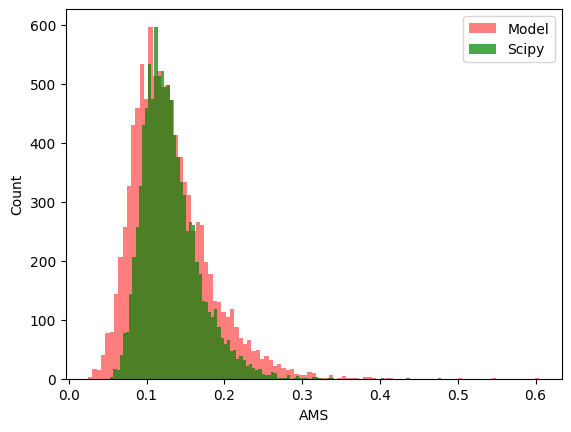

In [366]:
# Viganego -> index 10575
util.compare_samples(dist_test_full, "gumbel", parameters_test, seed = seed, index=10575)

### neg log like

In [367]:
loc, scale, ams = test_df_std[['loc', 'scale', 'AMS']].values.T
dist = tfp.distributions.Gumbel(loc = loc, scale = scale)
losses = -dist.log_prob(ams)
loss_full_scipy = np.mean(losses)

print(loss_full_scipy)

-1.7342187708567554


In [368]:
# FULL
loss_full_pred = full_model.evaluate(X_test, y_test)
print(loss_full_pred)

  1/353 [..............................] - ETA: 14s - loss: -1.5143

353/353 [==============================] - 1s 3ms/step - loss: -1.7063
-1.7062846422195435


In [369]:
# MAP
loss_map_pred = map_model.evaluate(X_test_map, y_test)
print(loss_map_pred)

353/353 [==============================] - 1s 2ms/step - loss: -1.7047
-1.704684853553772


In [370]:
# PCA
loss_pca_pred = pca_model.evaluate(X_test_pca, y_test)
print(loss_pca_pred)

353/353 [==============================] - 1s 2ms/step - loss: -1.7034
-1.7034320831298828


## 6. Save results 


In [371]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_scale_map, metrics_scale_full, metrics_scale_pca]

In [372]:
scale_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
scale_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,0.006456,-0.085775,-0.030341,0.108201,0.129527,0.125401,0.318269,0.486326,0.194555
1,0.022324,-0.051470,0.069772,0.084826,0.095882,0.101467,-0.010904,0.273175,0.263080
3,0.013176,-0.093183,-0.012683,0.114311,0.127052,0.115395,-0.089721,0.470486,0.275145
6,0.002147,-0.103838,-0.061526,0.114505,0.142660,0.129277,-0.042969,0.450703,0.226719
12,0.018898,-0.080861,-0.073844,0.119720,0.134270,0.145779,-0.007712,0.431173,0.149116
24,-0.024337,-0.099574,-0.073555,0.107652,0.147823,0.135116,-0.065806,0.308774,0.132509


In [373]:
models_metrics = [ metrics_loc_map, metrics_loc_full, metrics_loc_pca]
loc_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
loc_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.001069,0.016440,0.007133,0.024692,0.028934,0.028752,0.267828,0.465206,0.211730
1,-0.007224,0.013180,-0.010507,0.022378,0.025902,0.024607,-0.014732,0.257803,0.320090
3,-0.000021,0.015964,0.001905,0.024064,0.028256,0.026124,-0.067319,0.434867,0.339534
6,0.001195,0.018046,0.011734,0.026015,0.031249,0.030340,-0.004487,0.430828,0.243312
12,-0.000615,0.015140,0.015276,0.026201,0.028126,0.031501,-0.062211,0.414908,0.124216
24,0.001327,0.019879,0.017287,0.024803,0.031142,0.031194,-0.067017,0.360546,0.092298


In [374]:
#export as pkl file  loc and scale metrics
loc_metrics.to_pickle('results/loc_metrics.pkl')
scale_metrics.to_pickle('results/scale_metrics.pkl')
